In [14]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

np.random.seed(0)
GeneBCMatrix = collections.namedtuple('GeneBCMatrix',
                                      ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'],
                                           dsets['indices'],
                                           dsets['indptr']),
                                           shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'],
                                dsets['gene_names'],
                                dsets['barcodes'],
                                matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids,
                        gbm.gene_names,
                        gbm.barcodes[barcode_indices],
                        gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

#Create an N-dimentional nested dictionary
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))

#Function to define the turning point of a cumulative curve by using the minimum derivative method
def turn_point(sgRNA_name, df):
    sgRNA_count  = df.T.filter(items=[sgRNA_name]).sum(axis=1).sort_values(ascending=False)
    sgRNA_cumsum = sgRNA_count.cumsum()

    #get the total cell number of this sgRNA
    cell_num = np.argwhere(sgRNA_count > 0).size

    #calculate the turning point by using the max derivative
    turning_point = sgRNA_cumsum.loc[((sgRNA_cumsum.diff()) / sgRNA_count.sum() > (1/cell_num))].shape
    
    return(sgRNA_count.iloc[turning_point])

#load sgRNA-barcode data
def load_data(input_file):
    input_fh  = open(input_file, 'r')
    #define parameters
    cell_bc_list   = []
    num_sgRNA_list = np.array([])
    sgRNAs         = []
    umis           = []
    
    #initiate a 2D dictionary
    data_dict = nested_dict(2, list)
    for line in input_fh:
        cell_bc    = line.strip().split('\t')[0]
        num_sgRNA  = line.strip().split('\t')[2]
        sgRNA_list = line.strip().split('\t')[3].split(';')
        umi_list   = line.strip().split('\t')[5].split(';')
        full_cell_bc = cell_bc + '-1'
        for i in zip(sgRNA_list, umi_list):
            data_dict[full_cell_bc][i[0]] = i[1]
    
    #read the 2D dictionary into the pandas DataFrame
    df = pd.DataFrame(data_dict).fillna(0).astype(int)    
    return df

#filter the sgRNA UMI count based on the cutoff values
def filter_umi (df):
    #calculate the cutoff value for each sgRNA in the dataset
    sgRNA_cutoff = [[turn_point(i, df)] for i in list(df.index)]
    
    for i in range(0, len(sgRNA_cutoff)):
        df.iloc[i, :].loc[df.iloc[i, :] <= sgRNA_cutoff[i]] = 0
    return df

#fine the indecies of cells which contain the input sgRNA
def find_sgrna_cells(sgRNA_list, df, gbm):
    cell_bc = df.loc[:, (df.loc[sgRNA_list].sum() > 0)].T.index
    cell_index = []
    for i in cell_bc:
        current_idx = np.argwhere(gbm.barcodes == i.encode('utf-8'))
        if  current_idx.size > 0:
            cell_index.append(current_idx.item())
    return [x for x in set(cell_index)]

def find_non_zero_cells(df, gbm):
    cell_bc = df.T.loc[df.sum() != 0].index
    cell_index = []
    for i in cell_bc:
        current_idx = np.argwhere(gbm.barcodes == i.encode('utf-8'))
        if  current_idx.size > 0:
            cell_index.append(current_idx.item())
    return [x for x in set(cell_index)]

def hypergeo_test(non_zero_array, sgrna_idx, direction, i):
    #find indecies of cells in which expression of given gene is
    #equal or less than the median of this gene in the whole population
    if direction == 'down':
        median_cell_idx  = np.argwhere(non_zero_array <= np.median(non_zero_array))
    elif direction == 'up':
        median_cell_idx  = np.argwhere(non_zero_array >= np.median(non_zero_array))
        
    #find the same cells subset in the cells with a given sgRNA
    overlap_cell_idx = np.intersect1d(median_cell_idx, sgrna_idx)
    
    #perform hypergeometric test, get the upper tail
    k = len(overlap_cell_idx)
    M = len(non_zero_array)
    n = len(median_cell_idx)
    N = len(sgrna_idx)

    try:
        pval = stats.hypergeom.sf(k, M, n, N).item()
    except:
        pval = float('nan')
        
    return pval

def perform_DE(sgrna_idx, input_array, direction, num_processes, pval_list):
    non_zero_pval_list = []
    with Pool(processes=num_processes) as p:
        for pval in p.starmap(hypergeo_test, zip(input_array,
                                                 itertools.repeat(sgrna_idx),
                                                 itertools.repeat(direction),
                                                 idx)):
            non_zero_pval_list.append(pval)

    for i in idx:
        pval_list[i] = non_zero_pval_list.pop(0)
    
    return len(sgrna_idx), pval_list

def FDR(x):
    """
    Assumes a list or numpy array x which contains p-values for multiple tests
    Copied from p.adjust function from R  
    """
    o = [i[0] for i in sorted(enumerate(x), key=lambda v:v[1],reverse=True)]
    ro = [i[0] for i in sorted(enumerate(o), key=lambda v:v[1])]
    q = sum([1.0/i for i in range(1,len(x)+1)])
    l = [q*len(x)/i*x[j] for i,j in zip(reversed(range(1,len(x)+1)),o)]
    l = [l[k] if l[k] < 1.0 else 1.0 for k in ro]
    return np.asarray(l)

In [6]:
'''
Read parameters for figure plotting
'''
cmap = matplotlib.cm.get_cmap('Set2')

#create cumsum list of the chromsomal position
length_list = [0, 249250621, 492449994, 690472424, 881626700,
               1062541960, 1233657027, 1392795690, 1539159712,
               1680373143, 1815907890, 1950914406, 2084766301,
               2199936179, 2307285719, 2409817111, 2500171864,
               2581367074, 2659444322, 2718573305, 2781598825,
               2829728720, 2881033286, 3036303846]

chr_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20',
             '21', '22', 'X', 'Y']
        
#read the gene annotation file for plotting, which re-ordered the genes based on their
#relative positions on the genome
annot_df = pd.read_csv('plot_annotation.txt', 
                       header = None, 
                       sep='\t',
                       names = ["idx", "gene_names", "chromosome", "pos", "strand", "color_idx"])

## Load the data
We first read: 
 1. the HDF5 file containing the gene expression matrix which is the output from the 10X pipeline
 2. the sgRNA summary file which is the output from the sgRNA processing pipeline
 
Then we filter the sgRNA reads based on the saturation curve of each sgRNA. 
The gene count matrix is then normalized to CPM.

In [2]:
#read the 10X hdf5 file
filtered_matrix_h5 = './filtered_gene_bc_matrices_h5.h5'
genome = 'refgenome_hg19_CROP_Guide-MS2_puro-2.1.0'
gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)
    
#load the sgRNA file
sgrna_file = './10X_libs.sgRNA_count.txt'
sgrna_df = load_data(sgrna_file)
    
#filter the sgRNA by a saturation curve-based method
sgrna_df_adj = filter_umi(sgrna_df)

In [13]:
#get rid of the cells with no detectable sgRNA
non_zero_cell_idx = find_non_zero_cells (sgrna_df_adj, gene_bc_matrix)
sub_gbm = subsample_matrix(gene_bc_matrix, non_zero_cell_idx)

#normalize the readcount data to cpm
cpm_matrix = np.array(sub_gbm.matrix / sub_gbm.matrix.sum(axis = 0) * 1000000)

'''
To simplify the process, we only handle the genes with detectable expression. 
The following steps will filter the gene with any expression.
'''
#mark the genes with expression
idx = np.where(np.sum(sub_gbm.matrix, axis = 1) != 0)[0]

#get rid of the sgRNA gene
idx = idx[idx != (len(sub_gbm.gene_names) - 1)]

#create input ndarray
input_array = np.array(cpm_matrix)[idx]

## Load the region of interests

Read the file containing the regions names and the sgRNAs targeting this region. An example of one line is shown as below:
```
chr11:5301900-5302050	GACTATGGGAGGTCACTAA;AGAGTGATGACTCCTATCT;CAGAACCAGAAGGCGGGGG
```

One can specify one or multiple sgRNAs in each line, so that cells containing all the given sgRNAs will be combined for the hypergeometric test.
Here we use the beta-globin HS2 enhancer as an example.

In [16]:
#load the region of interst from target sgRNA file. 
sgrna_dict  = {}
sgrnas_file = './region_of_interests.txt'
with open(sgrnas_file) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split("\t")
        sgrnas = sgrna_string.split(";")
        sgrna_dict.update({region_id : sgrnas})

In [17]:
sgrna_dict

{'chr11:5301900-5302050': ['GACTATGGGAGGTCACTAA',
  'AGAGTGATGACTCCTATCT',
  'CAGAACCAGAAGGCGGGGG']}

## Virtual FACS analysis and Plotting

In [24]:
#Here we set the number of threading to 16, change this number if your computer doesn't have this many cores.
num_processing = 16

#define the up or down regulated genes that want to be identified
direction = 'down'

Region in processing: chr11:5301900-5302050


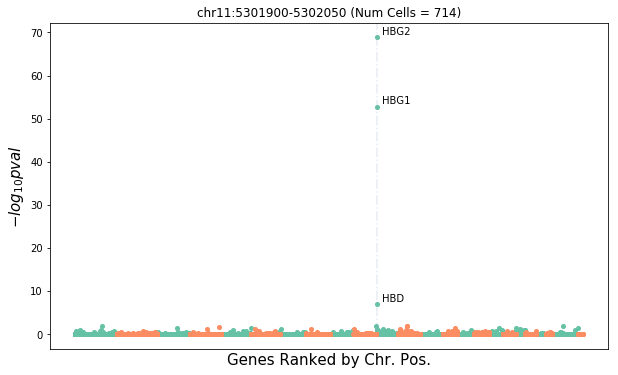

In [34]:
for k in sgrna_dict:
    print("Region in processing: " + k, file = sys.stderr)
        
    #idx index of cells containing the given sgRNA
    sgrna_idx = find_sgrna_cells(sgrna_dict[k], sgrna_df_adj, sub_gbm)

    #force the up-tail p-vals of all zero expressed genes to be zero. (actual p-val is 1)
    pval_list = [0] * (len(sub_gbm.gene_names) - 1)

    #perform the differential gene analysis by using Virtual FACS
    num_sgrna_cell, pval_list = perform_DE(sgrna_idx,
                                           input_array,
                                           direction,
                                           num_processing,
                                           pval_list)
    
    #get the FDR by using Benjamin-Hochberg methods
    adj_pval_list = FDR(pval_list)
    adj_pval_list[np.argwhere(adj_pval_list == 0)] = 1
        
    io.mmwrite('./%s-FDR_summary.mtx'%(k),
                csr_matrix(adj_pval_list))
    
    #get the location of the current target region
    enh_chrom, left, right = re.split(r'[:-]+', k)
    current_chrom = re.split(r'chr', enh_chrom)[1]
        
    #calculate the p_value for plotting
    y_val = -np.log10(adj_pval_list)
    y_val[np.isinf(y_val)] = 0
    plot_y_val = np.array(y_val)[annot_df.idx]

    #initiate the figure, get the y-axis values for plotting
    fig, ax  = plt.subplots(figsize=(10,6))
    odd_idx  = annot_df.index[annot_df.color_idx == 0]
    even_idx = annot_df.index[annot_df.color_idx == 1]

    plot_y_val = np.array(y_val)[annot_df.idx]

    #plot odd chromosomes
    ax.plot(annot_df.pos[odd_idx], plot_y_val[odd_idx],
            color = cmap(0), 
            marker = '.', 
            linestyle = 'None',
            MarkerSize = 8)
    
    #plot even chromosomes
    ax.plot(annot_df.pos[even_idx], plot_y_val[even_idx],
            color = cmap(1),
            marker = '.',
            linestyle = 'None',
            MarkerSize = 8)

    #plot a vertical line to indicate the target region
    ax.axvline(int(left)+length_list[chr_order.index(current_chrom)],
               ymin=0.05,
               color = cmap(2),
               linestyle='-.',
               alpha = 0.2)
    
    ax.set_ylabel('$-log_{10}pval$', fontsize = 15)
    ax.set_xlabel('Genes Ranked by Chr. Pos.', fontsize = 15)
    ax.set_xticks([])
    ax.set_title('%s (Num Cells = %d)'%(k, num_sgrna_cell))

    #plot the name of the point which the -log10(adj_pval) > 2
    outliers = np.atleast_1d(np.argwhere(plot_y_val > 2).squeeze())

    [xmin, xmax] = ax.get_xlim()
    [ymin, ymax] = ax.get_ylim()

    if np.any(outliers):
        for j in outliers:
            ax.text(annot_df.pos[j] + (xmax*0.01),
                    plot_y_val[j] + (ymax*0.01),
                    annot_df.gene_names[j])